<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель <br>Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 8. Часть 1
## <center> Реализация алгоритмов онлайн-обучения

В первой части задания вам предлагается реализовать два алгоритма – регрессор и классификатор, обучаемые стохастическим градиентным спуском (Stochastic Gradient Descent, SGD). [Веб-форма](https://goo.gl/forms/z8zENbMiaEAeB7nG3) для ответов.

## План 1 части домашнего задания
    1.1. Линейная регрессия и SGD
    1.2. Логистическая регрессия и SGD
    1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

В [статье](https://habrahabr.ru/company/ods/blog/326418/) было описано, как таким образом обучать регрессор, т.е. минимизировать квадратичную функцию потерь. Реализуем этот алгоритм.

Вначале проверим версии библиотек с помощью расширения [watermark](https://github.com/rasbt/watermark). Заодно и Vowpal Wabbit, который понадобится во 2 части задания – версия должна быть последняя на момент написания, 8.3.2.

In [1]:
#pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn 

CPython 3.6.1
IPython 5.3.0

numpy 1.12.1
scipy 0.19.0
pandas 0.19.2
matplotlib 2.0.0
sklearn 0.18.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)
system     : Darwin
release    : 16.5.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [3]:
!vw --version

8.3.1


##  1.1. Линейная регрессия и SGD

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Реализуйте класс `SGDRegressor`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$) и `n_iter` – число проходов по выборке (по умолчанию 10)
- также в конструкторе должны создаваться списки `mse_` и `weights_` для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit` и `predict`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса (см. [статью](https://habrahabr.ru/company/ods/blog/326418/)), а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки (именно MSE, SE слишком большими будут) и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDRegressor`, т.е. `self`
- Метод `predict` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом `fit` вектор весов `w_`.

In [5]:
class SGDRegressor(BaseEstimator):
    def __init__(self, eta=1e-3, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter
        self.mse_ = []
        self.weights_ = []
        
    def fit(self, X, y):
        X_ = np.hstack([np.ones([X.shape[0], 1]), X])
        w = np.zeros(X_.shape[1])
        dw = np.zeros(X_.shape[1])
        
        for _ in tqdm(range(self.n_iter)):
            for i in range(X_.shape[0]):
                dw[0] = self.eta * (y[i] - w.dot(X_[i, :]))
                
                for j in range(1, X_.shape[1]):
                    dw[j] = self.eta * (y[i] - w.dot(X_[i, :])) * X_[i, j]
                w = w + dw
                
                self.mse_.append(mean_squared_error(y, X_.dot(w)))
                self.weights_.append(w)

        self.w_ = self.weights_[np.argmin(self.mse_)]
        return self
    
    def predict(self, X):
        X_ = np.hstack((np.ones((X.shape[0], 1)), X))
        return X_.dot(self.w_)

Проверим работу алгоритма на данных по росту и весу. Будем прогнозировать рост (в дюймах) по весу (в фунтах).

In [6]:
data_demo = pd.read_csv('../../data/weights_heights.csv')

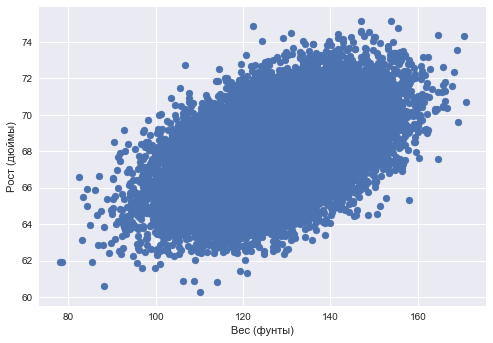

In [7]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Вес (фунты)')
plt.ylabel('Рост (дюймы)');

In [8]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

Обучите созданный вами `SGDRegressor` на выборке `(X_train_scaled, y_train)`. Параметры оставьте по умолчанию.

In [11]:
clf = SGDRegressor()
clf.fit(X_train_scaled, y_train)
print(X_train_scaled.shape)

100%|██████████| 10/10 [00:55<00:00,  4.93s/it]

(17500, 1)


Изобразите на графике процесс обучения – как среднеквадратичная ошибка зависит от номера итерации стохастического градиентного спуска.

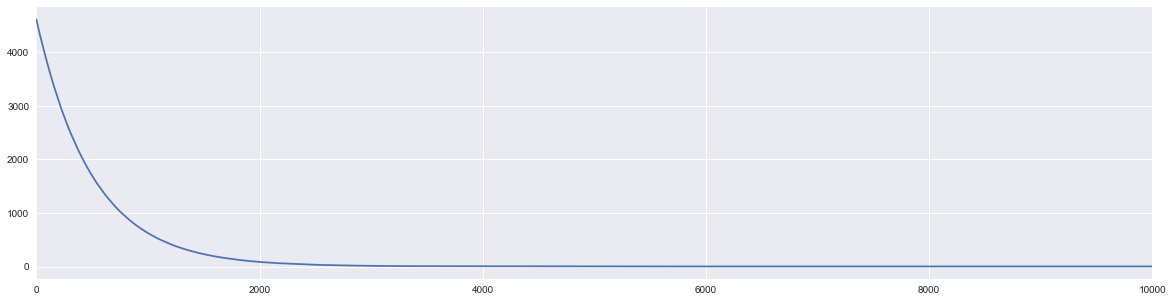

In [12]:
plt.figure(figsize=(20, 5))
plt.xlim((0, 10000))
plt.plot(clf.mse_)
plt.show()

Выведите наименьшее значение среднеквадратичной ошибки и лучший вектор весов модели.

In [13]:
print('Minimal MSE:', np.min(clf.mse_))
print('Weights:', clf.weights_[np.argmin(clf.mse_)])

Minimal MSE: 2.71513524066
Weights: [ 67.9898497    0.94447605]


Постройте график того, как менялись значения весов модели ($w_0$ и $w_1$) по мере обучения.

(0, 10000)

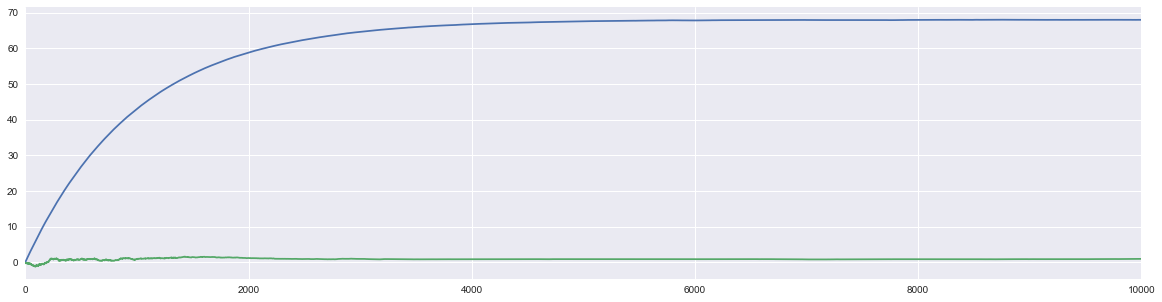

In [14]:
plt.figure(figsize=(20, 5))
plt.plot(clf.weights_)
plt.xlim((0, 10000))

Сделайте прогноз для отложенной выборки `(X_valid_scaled, y_valid)` и посмотрите на MSE.

In [15]:
y_predict = clf.predict(X_valid_scaled)
my_clf_mse = mean_squared_error(y_valid, y_predict)
my_clf_mse

2.6708681207033784

Теперь следайте то же самое, но с `LinearRegression` из `sklearn.linear_model`. Посчитайте MSE для отложенной выборки.

In [16]:
import math
from sklearn.linear_model import LinearRegression

clf_lr = LinearRegression(n_jobs=8)
clf_lr.fit(X_train_scaled, y_train)
lr_mse = mean_squared_error(y_valid, clf_lr.predict(X_valid_scaled))
print(lr_mse)
print(my_clf_mse)

2.67083076767
2.6708681207


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


<font color='red'>Вопрос 1.</font> В каком знаке после разделителя отличаются MSE линейной регрессии и `SGDRegressor` для отложенной выборки?
 - 2
 - 3
 - 4
 - **5**
 

## 1.2. Логистическая регрессия и SGD
Теперь давайте разберемся, как при таком же стохастическом подходе обучать логистическую регрессию.

Задача классификации, $X$ – обучающая выборка размеров $\ell \times (d+1)$ (первый столбец – вектор из единиц), $y$ – вектор ответов, $y_i \in \{-1, 1\}$.
В [4 статье](https://habrahabr.ru/company/ods/blog/323890/) серии мы подробно разбирали, как логистическая регрессия с $L_2$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

<font color='red'>Вопрос 2.</font> По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском?
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) +  \delta_{j\neq0} w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) +  \delta_{j\neq0}w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) -  \delta_{j\neq0}w_j )$
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j)$ -- right answer
 
Здесь 
- $i \in {0,\ldots, \ell-1}, j \in {0,\ldots, d}$
- C – коэффициент регуляризации
- $x_{ij} $ – элемент матрицы X в строке $i$ и столбце $j$ (нумерация с 0), 
- $x_i$ – $i$-ая строка матрицы $X$ (нумерация с 0), 
- $w_j^{(t)}$ – значение $j$-ого элемента вектора весов $w$ на шаге $t$ стохастического градиентного спуска
- $\eta$ – небольшая константа, шаг градиентного спуска
- $\delta_{j\neq0}$ – символ Кронекера, то есть 1, когда $j\neq0$ и $0$ – в противном случае

Реализуйте класс `SGDClassifier`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$), `n_iter` – число проходов по выборке (по умолчанию 10) и C – коэффициент регуляризации
- также в конструкторе должны создаваться списки `loss_` и `weights_` для отслеживания значений логистических потерь и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit`, `predict` и `predict_proba`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`, рассматриваем только случай бинарной классификации, и значения в векторе `y` могут быть -1 и 1), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса по выведенной вами формуле, а также записывает получившиеся на данной итерации значения log_loss и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDClassifier`, т.е. `self`
- Метод `predict_proba` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает матрицу прогнозов модели (такую же, какую возвращают методы `predict_proba` моделей `sklearn`), используя созданный методом `fit` вектор весов `w_`
- Метод `predict` вызывает метод  `predict_proba` и возвращает вектор ответов: -1, если предсказанная вероятность класса 1 меньше 0.5 и 1 – в противном случае
- И еще **важный момент**: во избежание вычислительных проблем из-за слишком больших или малых значений под экспонентной (overflow & underflow) используйте написанную функцию `sigma`

In [17]:
def sigma(z):
    z = z.flatten()
    z[z > 100] = 100
    z[z < -100] = -100
    return 1. / (1 + np.exp(-z))

sign_v = np.vectorize(lambda x: -1 if x < 0.5 else 1)

In [18]:
class SGDClassifier(BaseEstimator):
    def __init__(self, C, eta=1e-3, n_iter=10):
        self.C = C
        self.eta = eta
        self.n_iter = n_iter
        self.loss_ = []
        self.weights_ = []
        
    def fit(self, X, y):
        X_ = np.hstack([np.ones([X.shape[0], 1]), X])
        w = np.zeros(X_.shape[1])
        dw = np.zeros(X_.shape[1])
        
        for _ in tqdm(range(self.n_iter)):
            for i in range(X_.shape[0]):
                dw[0] = self.eta * self.C * y[i] * sigma(- y[i] * w.dot(X_[i, :]))
                for j in range(1, X.shape[1]):
                    dw[j] = self.eta * (self.C * y[i] * X_[i, j] * sigma(-y[i] * w.dot(X_[i, :])) -  w[j])
                w = w + dw
                
                self.loss_.append(log_loss(y, sigma(X_.dot(w))))
                self.weights_.append(w)

        self.w_ = self.weights_[np.argmin(self.loss_)]
        return self
    
    def predict(self, X):
        probs = self.predict_proba(X)[:, 1]
        return sign_v(probs)
    
    def predict_proba(self, X):
        X_ = np.hstack([np.ones([X.shape[0], 1]), X])
        pred_ = sigma(X_.dot(self.w_)).reshape([X_.shape[0], 1])
        return np.hstack([1 - pred_, pred_])

Проверим `SGDClassifier` на данных UCI по раку молочной железы.

In [19]:
from sklearn.datasets import load_breast_cancer

In [20]:
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [23]:
X_train_scaled.shape

(398, 30)

Обучите на масштибированной выборке `SGDClassifier` с параметрами `C`=1, `eta`=$10^{-3}$ и `n_iter`=3.

In [24]:
clf = SGDClassifier(C=1, eta=1e-3, n_iter=3)
clf.fit(X_train_scaled, y_train)

100%|██████████| 3/3 [00:01<00:00,  1.68it/s]


SGDClassifier(C=1, eta=0.001, n_iter=3)

Постройте график изменения log_loss.

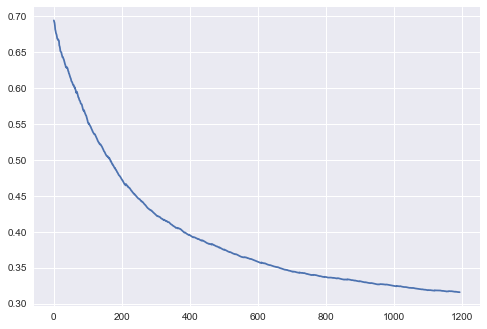

In [25]:
plt.plot(clf.loss_)

Теперь обучите `SGDClassifier` с параметром `C`=1000, число проходов по выборке увеличьте до 10.

100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


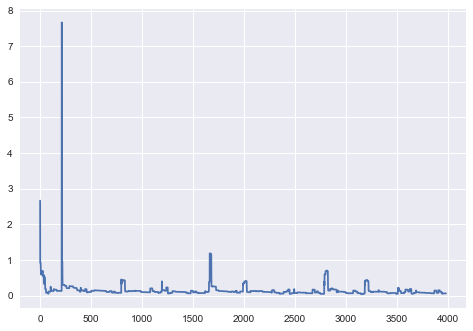

In [26]:
clf = SGDClassifier(C=1000, eta=10**-3, n_iter=10)
clf.fit(X_train_scaled, y_train)
plt.plot(clf.loss_)

Посмотрите на веса модели, при которых ошибка на обучении была минимальна.

<font color='red'>Вопрос 3.</font> Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели `SGDClassifier`? (будьте внимательны – проверьте длину вектора весов, полученного после обучения, сравните с числом признаков в исходной задаче)
 - worst compactness
 - worst smoothness
 - **worst concavity**
 - concave points error
 - concavity error
 - compactness error
 - worst fractal dimension

In [27]:
cancer.feature_names[np.argmax(np.abs(clf.w_[1:]))]

'worst concavity'

Посчитайте log_loss и ROC AUC на отложенной выборке, проделайте все то же с `sklearn.linear_model.LogisticRegression` (параметры по умолчанию, только random_state=17) и сравните результаты.

In [28]:
from sklearn.linear_model import LogisticRegression

clf_logr = LogisticRegression(random_state=17)
clf_logr.fit(X_train_scaled, y_train)

print('Log loss [SGDClassifier]:\t', log_loss(y_valid, clf.predict_proba(X_valid_scaled)))
print('Log loss [LogisticRegression]:\t', log_loss(y_valid, clf_logr.predict_proba(X_valid_scaled)))

print('AUC-ROC [SGDClassifier]:\t', roc_auc_score(y_valid, clf.predict_proba(X_valid_scaled)[: , 1]))
print('AUC-ROC [LogisticRegression]:\t', roc_auc_score(y_valid, clf_logr.predict_proba(X_valid_scaled)[:, 1]))

Log loss [SGDClassifier]:	 0.372777136662
Log loss [LogisticRegression]:	 0.105692134779
AUC-ROC [SGDClassifier]:	 0.976005961252
AUC-ROC [LogisticRegression]:	 0.989269746647


## 1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

Теперь посмотрим на логистическую регрессию и ее же версию, но обучаемую стохастическим градиентным спуском, в задаче классификации отзывов IMDB. С этой задачей мы знакомы по 4 и 8 темам курса. Данные можно скачать [отсюда](https://yadi.sk/d/Tg1Tflur333iLr).

Импортируем файлы, и обучим на имеющихся данных `CountVectorizer`

In [29]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [30]:
# поменяйте путь к файлу
reviews_train = load_files("../../data/imdb_reviews/train")
text_train, y_train = reviews_train.data, reviews_train.target

In [31]:
reviews_test = load_files("../../data/imdb_reviews/test")
text_test, y_test = reviews_test.data, reviews_test.target

Обучим на имеющихся данных `CountVectorizer`, считая биграммы, то есть перейдем к разреженному представлению данных, где каждому уникальному слову и паре подряд идущих слов в обучающей выборке соответсвует признак. Всего таких признаков получается более 1.5 млн.

In [32]:
%%time
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)

CPU times: user 46.3 s, sys: 1.34 s, total: 47.7 s
Wall time: 56 s


In [33]:
X_train.shape, X_test.shape

((25000, 1513832), (25000, 1513832))

Обучите на выборке `(X_train, y_train)` логистическую регрессию с параметрами по умолчанию (только укажите `random_state`=17) и посчитайте ROC AUC на тестовой выборке. Замерьте время обучения модели. Данные можно не масштабировать, так как признаки – по сути, счетчики, и они уже все измеряются примерно в одном диапазоне.

In [34]:
%%time
clf_logr = LogisticRegression(random_state=17)
clf_logr.fit(X_train, y_train)

CPU times: user 55.9 s, sys: 717 ms, total: 56.6 s
Wall time: 1min


Теперь перейдем к онлайн-алгоритму. Мы написали свой `SGDClassifier` и принцип его работы поняли, надо еще немного постараться, чтобы сделать его эффективным, например, сделать поддержку разреженных данных. Но мы теперь перейдем к `sklearn`-реализации SGD-алгоритма. Прочитайте документацию [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), сделайте выводы, чем `SGDClassifier` из `Sklearn` более продвинут, чем наша реализация SGD-классификатора. 

<font color='red'>Вопрос 4.</font> Чем `sklearn`-реализация стохастического классификатора более продвинута, чем `SGDClassifier`, который мы реализовали? Отметьте все подходящие варианты.
 - **Изменяемый шаг градиентного спуска**
 - **Реализован линейный SVM**
 - Реализована ранняя остановка во избежание переобучения
 - **Есть распараллеливание по процессорам**
 - Можно обучать LASSO
 - Поддерживается онлайн-обучение деревьев решений
 - **Поддерживается mini-batch подход (обновление весов по нескольким объектам сразу, а не по одному)**


Проведите 100 итераций SGD-логрегрессии (опять `random_state`=17) на той же выборке. Опять замерьте время обучения модели и обратите внимание, насколько оно меньше, чем время обучения логистической регрессии.

In [35]:
%%time
from sklearn.linear_model import SGDClassifier

clf_sgd = SGDClassifier(random_state=17, n_iter=100, loss='log')
clf_sgd.fit(X_train, y_train)

CPU times: user 9.04 s, sys: 112 ms, total: 9.16 s
Wall time: 9.87 s


<font color='red'>Вопрос 5.</font> В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора `Sklearn` с логистической функцией потерь?
 - 2
 - **3**
 - 4
 - 5

In [36]:
print(roc_auc_score(y_test, clf_logr.predict_proba(X_test)[:, 1]))
print(roc_auc_score(y_test, clf_sgd.predict_proba(X_test)[:, 1]))

0.958246912
0.9573458688
